# Exploring Apartment Offers in Wrocław: April 2021

In this notebook, we will dive into a dataset of 17,000 apartment offers available on Otodom.pl for the city of Wrocław as of April 2021.Using various data science libraries in Python, we will explore and analyze this dataset to gain insights into the local real estate market.  

First, we will import the necessary libraries and set some visualizations parameters using seaborn.


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(16,9)})
sns.set_context('talk')
pd.set_option('display.max_columns', 15)
pd.set_option('display.width', 2000)

Next, we will read in the dataset from a CSV file using pandas and check for any missing values in the df DataFrame:

In [2]:
df = pd.read_csv('data/Sell_Wroclaw_Total_2021-04-11.csv')
df.isnull().describe()

,id,price,price_m,area,room,year,loc,url,offer,seller,addons,market,floor,floor_count
count,17688,17688,17688,17688,17688,17688,17688,17688,17688,17688,17688,17688,17688,17688
unique,1,1,1,1,1,1,1,1,1,1,2,1,1,1
top,False,False,False,False,False,False,False,False,False,False,False,False,False,False
freq,17688,17688,17688,17688,17688,17688,17688,17688,17688,17688,16405,17688,17688,17688


We can see that the addons column has some NaN values, which represent offers without any additional checked information. We can replace these with 0 to make the dataset more consistent:

In [3]:
df['addons'].fillna(0, inplace=True)

## Data Transformation for Improved Analysis

To improve the presentation of our data, we will perform several transformations on the dataset. First, we will remove any offers without a listed price:

In [4]:
df = df[df['price'] != 'ask for price']
df = df[df['price_m'] != 'ask for price']

Next, we will transform the remaining price values from strings to integers:

In [5]:
df['price'] = df['price'].astype(int)

To segment the price per meter column, we will round each value to the nearest 500 zł for easier analysis: 

In [6]:
df['price_m'] = df['price_m'].astype(int).apply(lambda x: int(x/500)*500)

We will also round the area column to the nearest 2 meters squared for better segmentation:

In [7]:
df['area'] = df['area'].apply(lambda x: int(x/2)*2)

To simplify the number of categories for the number of rooms, we will group all offers with 5 or more rooms into a single category:

In [8]:
df['room'] = df['room'].apply(lambda x: x if x in ('1','2','3','4') else '5 and more')

For the year of construction column, we will group all offers built before 2020 into decade categories, and those built in 2020 or later will be counted on a year-by-year basis:

In [9]:
df['year'] = df['year'].apply(lambda x: x if x >= 2020 else int(x/10)*10)

After these transformations, we are left with a more manageable and standardized dataset for analysis. Here are some basic statistics for the remaining data:

In [10]:
df.describe().round(2)

,price,price_m,area,year,market,floor_count
count,17060.00,17060.00,17060.00,17060.00,17060.00,17060.00
mean,507864.85,8735.17,56.38,1695.30,0.66,3.82
std,265074.50,2290.93,22.86,755.78,0.47,3.21
min,38000.00,2000.00,12.00,0.00,0.00,0.00
25%,373230.00,7000.00,42.00,1980.00,0.00,2.00
50%,449000.00,8500.00,52.00,2020.00,1.00,4.00
75%,559757.50,9500.00,66.00,2021.00,1.00,5.00
max,6000000.00,34000.00,750.00,20201.00,1.00,52.00


We will perform further transformations and analysis on this dataset in the following sections.

## Data Overview

### Offer Count by Apartment Area

The most common apartment sizes are in the range of 40-60 square meters, with a peak around 48 square meters.

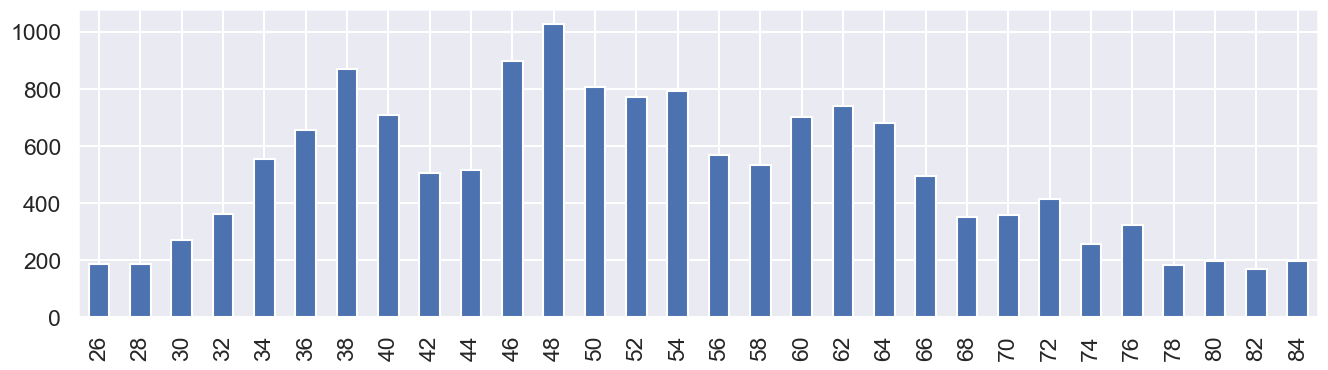

In [11]:
df['area'].value_counts().head(30).sort_index().plot.bar(stacked=True, figsize=(16,4))
plt.show()

### Offer Count by Room Count

The majority of offers have 2-4 rooms, with 2-room apartments being the most common.

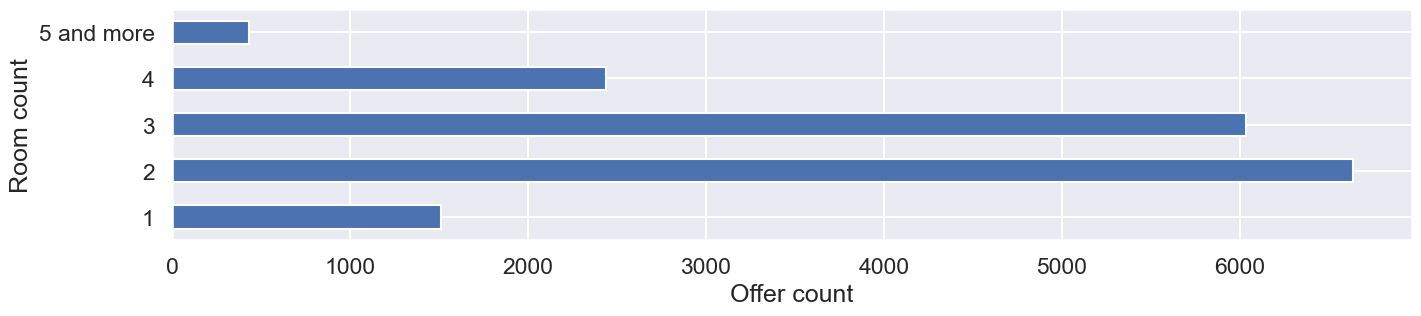

In [12]:
df['room'].value_counts().sort_index().head(5).plot(kind='barh', figsize=(16,3))
plt.ylabel('Room count')
plt.xlabel('Offer count')
plt.show()

### Distribution of Room Counts by Apartment Area

Combining the two previous graphs into one, we can gain a deeper understanding of the relationship between apartment area and room count. 

The majority of apartments have 1-3 rooms and are typically smaller in size, with an area of 30-40 square meters. As the area increases, the number of rooms tends to increase as well, with a higher proportion of apartments having 3-5 rooms in larger areas. There are also some outliers with larger areas but fewer rooms, which could indicate a different type of property, such as a studio or loft.

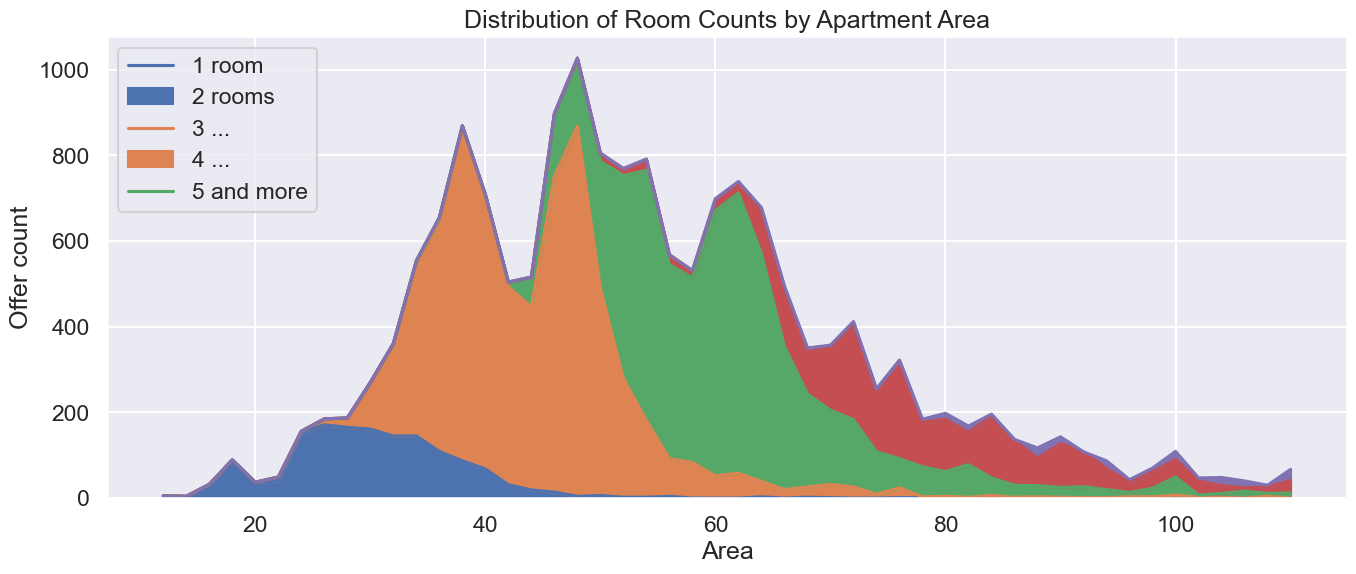

In [13]:
df[['area', 'room']].pivot_table(index=df['area'], columns='room', aggfunc='count').head(50).plot(kind='area', stacked=True, figsize=[16,6])
plt.ylabel('Offer count')
plt.xlabel('Area')
plt.title('Distribution of Room Counts by Apartment Area')
plt.legend(['1 room','2 rooms','3 ...','4 ...','5 and more'], loc='upper left')
plt.show()

### Offer Count by Year of Construction

The visualization shows the number of offers in relation to the year of construction, grouped into decades up to 2020.
The data reveals a significant spike in offer count for apartments built in 2020, with a record high of 2,923 offers. The year 2021 had an even higher number of offers at 4,272, with some of these being completed and available for use, while others are future offers like additional 2,084 offers recorded for the year 2022.

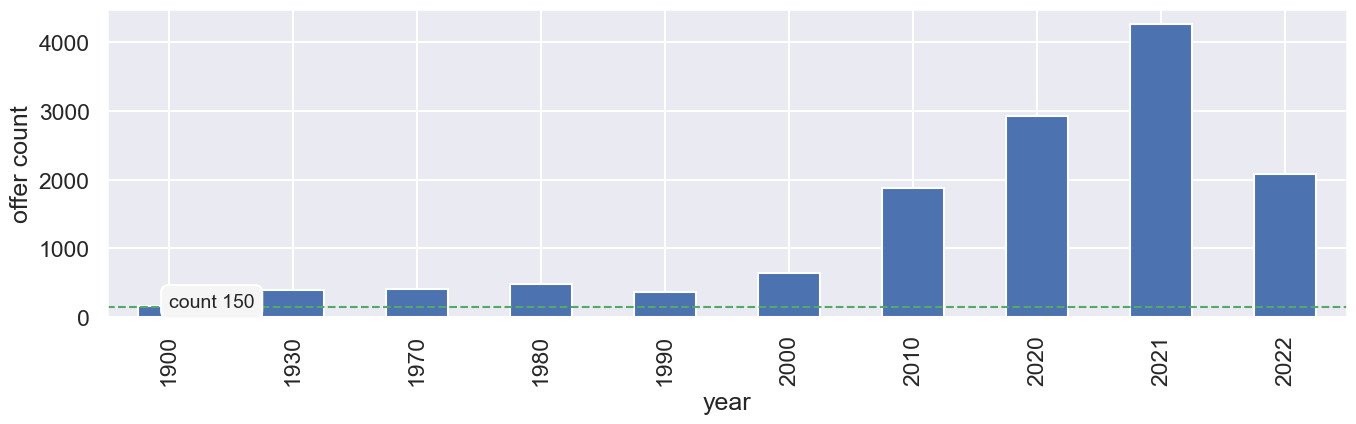

In [14]:
df[df['year'] != 0]['year'].value_counts().head(10).sort_index().plot(kind='bar', figsize=(16,4))
plt.ylabel('offer count')
plt.xlabel('year')
plt.axhline(y=150, color='g', linestyle='--', linewidth=1.5)
plt.text(x=0, y=150, s="count 150", fontsize=14, bbox=dict(facecolor='whitesmoke', boxstyle="round, pad=0.4"))
plt.show()

### Top 10 Offer Counts by Seller

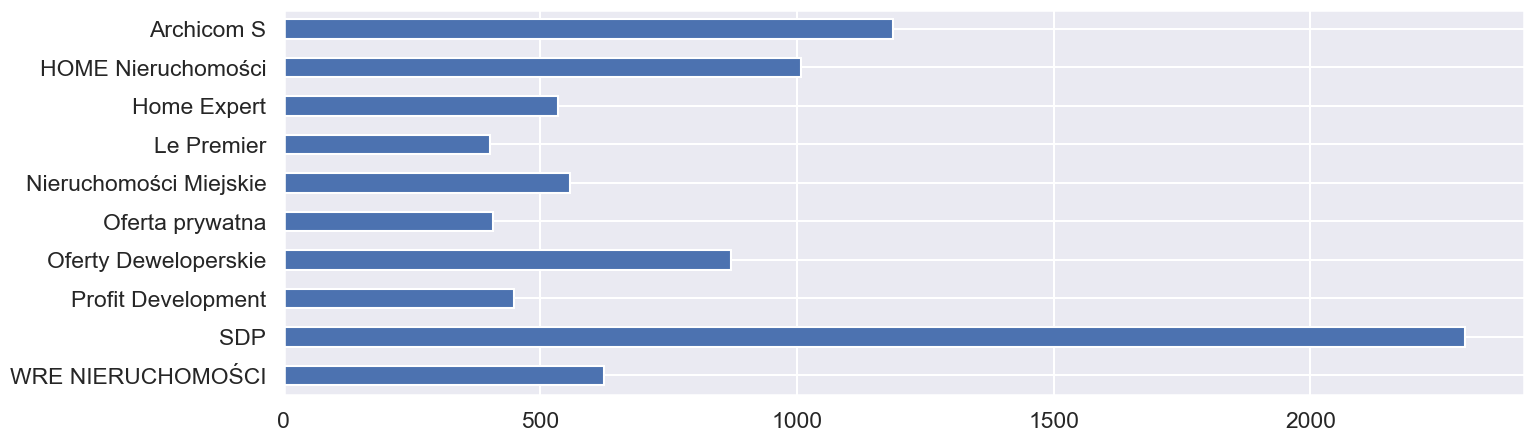

In [15]:
df['seller'].value_counts().head(10).sort_index(ascending=False).plot(kind='barh', figsize=(16,5))
plt.show()

### Distribution of Offers by Market Type

`0` means this is aftermarket offer nad `1` means this is primary offer.

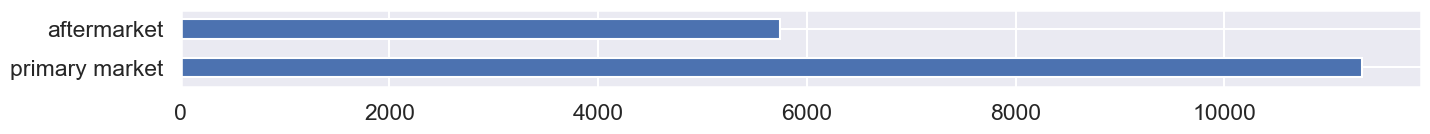

In [16]:
df['market'].value_counts().plot(kind='barh', figsize=(16,1)).set_yticklabels(['primary market','aftermarket'])
plt.show()

### Top 6 Most Frequent Apartment Floors in Offers

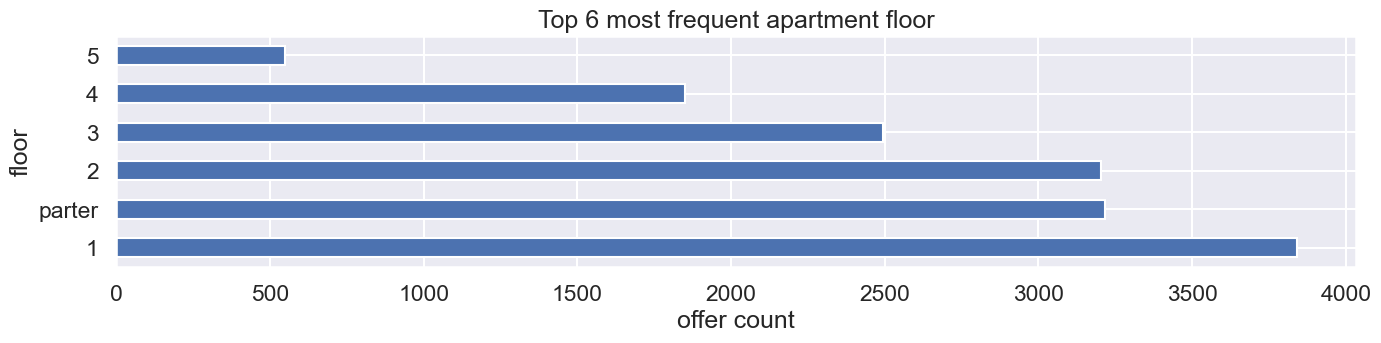

In [17]:
index = df['floor'] != '0'  # remove offers without apartment floor information
ax = df[index]['floor'].value_counts().head(6).plot(kind='barh', figsize=(16,3))
ax.set(xlabel='offer count', ylabel='floor', title='Top 6 most frequent apartment floor')
plt.show()

### Top 6 Most Frequent Building Heights in Offers

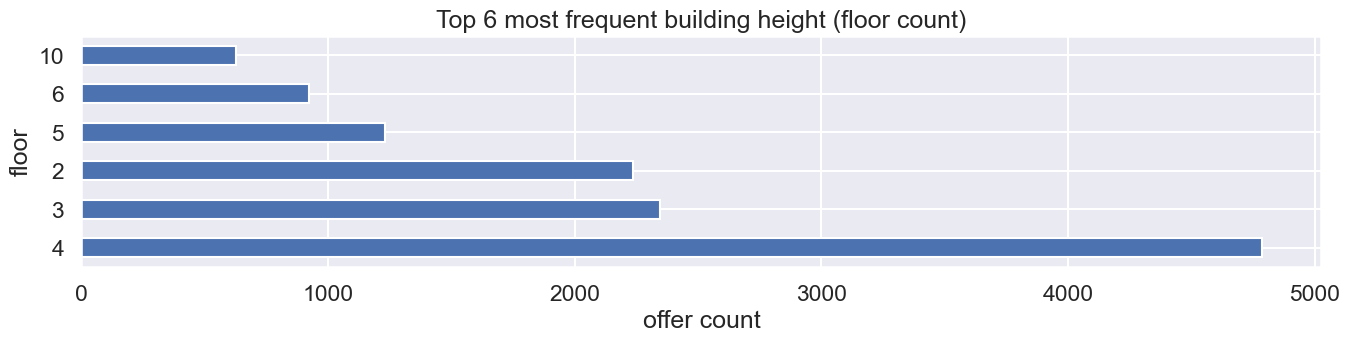

In [18]:
index = df['floor_count'] != 0  # remove offers without floor count information
ax = df[index]['floor_count'].value_counts().head(6).plot(kind='barh', figsize=(16,3))
ax.set(xlabel='offer count', ylabel='floor', title='Top 6 most frequent building height (floor count)')
plt.show()

## Creating Additional Real Estate Feature Columns

To provide better insight for market options, new columns were created for specific real estate features. If an offer had the feature, the column value was set to 1; otherwise, it was set to 0. The following features were included:balkon, garaż/miejsce (parking space/garage), dwupoziomowe (two-level apartment), teren zamknięty (closed area), ogródek (garden), taras (terrace), piwnica (basement), kuchnia (kitchen), and winda (elevator).

In [19]:
cols = ['balkon', 'garaż/miejsce', 'dwupoziomowe', 'teren zamknięty', 'ogródek', 'taras', 'piwnica', 'kuchnia', 'winda']

def create_columns(cols):
    for i in range(len(cols)):
        df.loc[df['addons'].str.contains(cols[i], na=False), cols[i]] = 1
    df.fillna(0, inplace=True)

create_columns(cols)
df[cols].describe().head(2)

,balkon,garaż/miejsce,dwupoziomowe,teren zamknięty,ogródek,taras,piwnica,kuchnia,winda
count,17060.0000,17060.000000,17060.000000,17060.000000,17060.000000,17060.000000,17060.000000,17060.000000,17060.000000
mean,0.5568,0.547245,0.021336,0.102403,0.095838,0.114654,0.187984,0.199179,0.533646


The mean values represents percentage share of market for each additional feature, as they were created using a binary description: 0 for non-existent and 1 for existing features. To visualize the results, the mean values were multiplied by 100% and plotted in a bar graph.

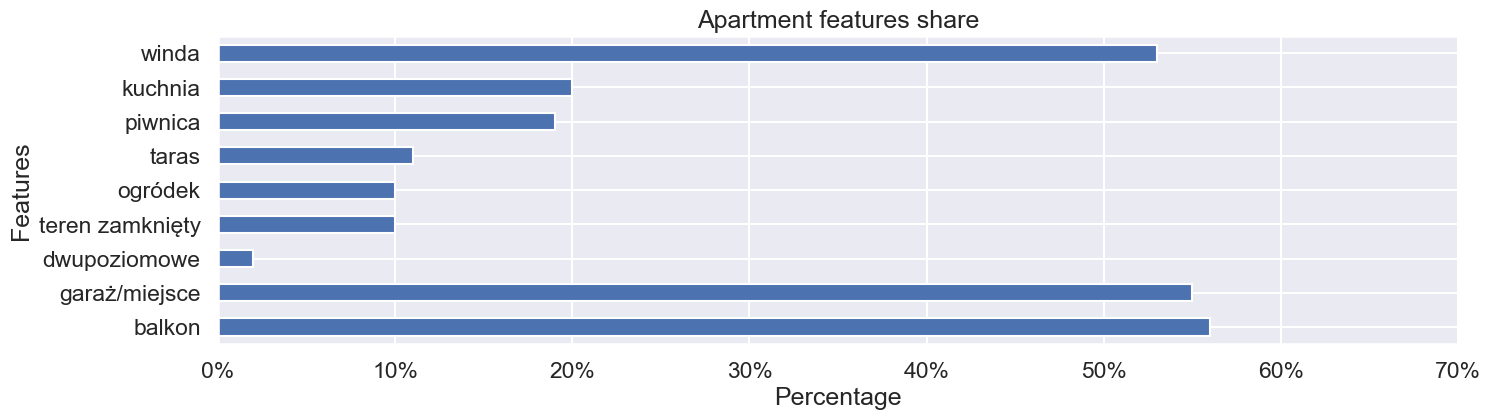

In [20]:
dfs = df[cols].mean().round(2) * 100
ax = dfs.plot(kind='barh', figsize=(16,4), xlim=(0,70), title='Apartment features share')
ax.set_xlabel('Percentage')
ax.set_ylabel('Features')
ax.set_xticks(range(0, 71, 10))
ax.set_yticklabels(dfs.index)
ax.set_xticklabels([f'{x}%' for x in range(0, 71, 10)])
plt.show()

To analyze the distribution of these features for primary and aftermarket offers separately, the same visualization was repeated for each market category.




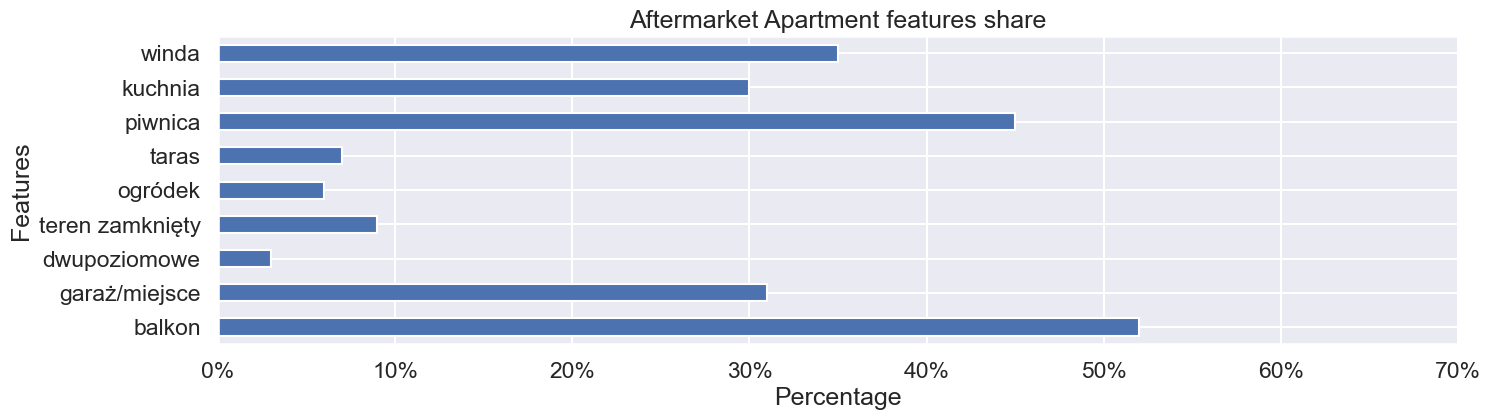

In [21]:
dfs = df[df['market'] == 0][cols].mean().round(2) * 100
ax = dfs.plot(kind='barh', figsize=(16,4), xlim=(0,70), title='Aftermarket Apartment features share')
ax.set_xlabel('Percentage')
ax.set_ylabel('Features')
ax.set_xticks(range(0, 71, 10))
ax.set_yticklabels(dfs.index)
ax.set_xticklabels([f'{x}%' for x in range(0, 71, 10)])
plt.show()

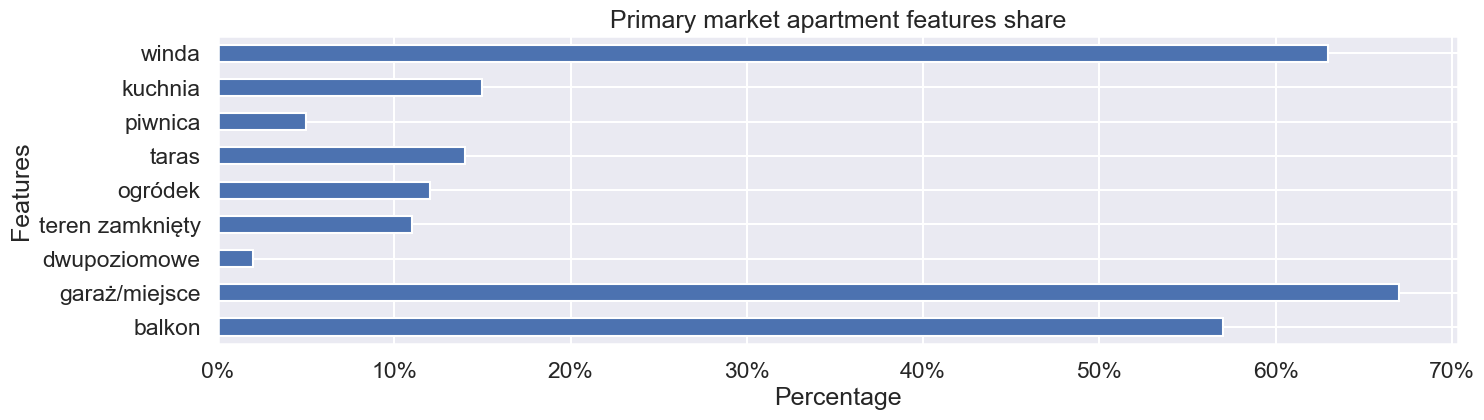

In [22]:
dfs = df[df['market'] == 1][cols].mean().round(2) * 100
ax = dfs.plot(kind='barh', figsize=(16,4), color='b', title='Primary market apartment features share')
ax.set_xlabel('Percentage')
ax.set_ylabel('Features')
ax.set_xticks(range(0, 71, 10))
ax.set_yticklabels(dfs.index)
ax.set_xticklabels([f'{x}%' for x in range(0, 71, 10)])
plt.show()

It is interesting to note that the <b>garaż/miejsce</b> feature is included in 70% of primary market offers. This is likely due to the fact that parking spaces are often sold at an additional cost and are mandatory to purchase with the apartment. Prices for parking spaces can range from 20,000 to 50,000 PLN, so it should be expected that the final price of an apartment with a
parking space will be higher than presented on website.

## Price per Meter - Trends in Offer Counts

### Relationship between Price per Meter and Offer Count by Room Count

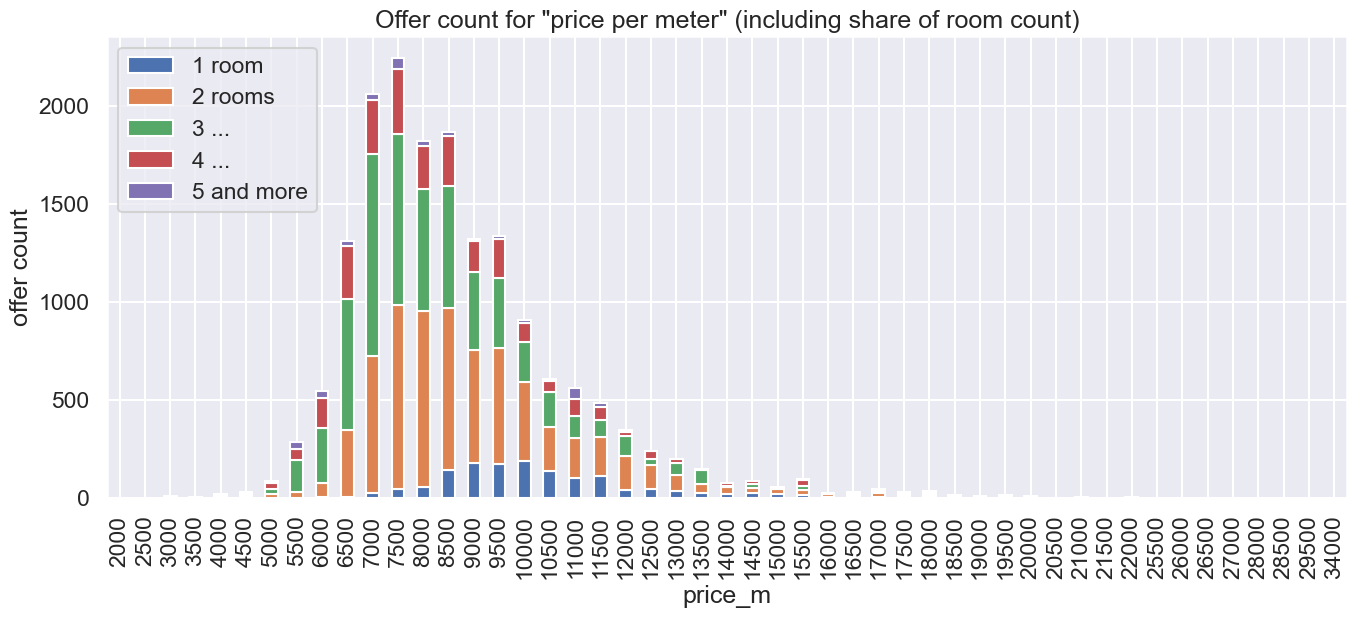

In [23]:
dfs = df[['price_m', 'room']].pivot_table(index='price_m', columns='room', aggfunc=len)
ax = dfs.plot(kind='bar', stacked=True, figsize=[16,6], xlim=(4000,15000))
ax.set(xlabel='price_m', ylabel='offer count', title='Offer count for "price per meter" (including share of room count)')
plt.legend(['1 room','2 rooms','3 ...','4 ...','5 and more'], loc='upper left')
plt.show()

### Relationship between Price per Meter and Offer Count by Building Height

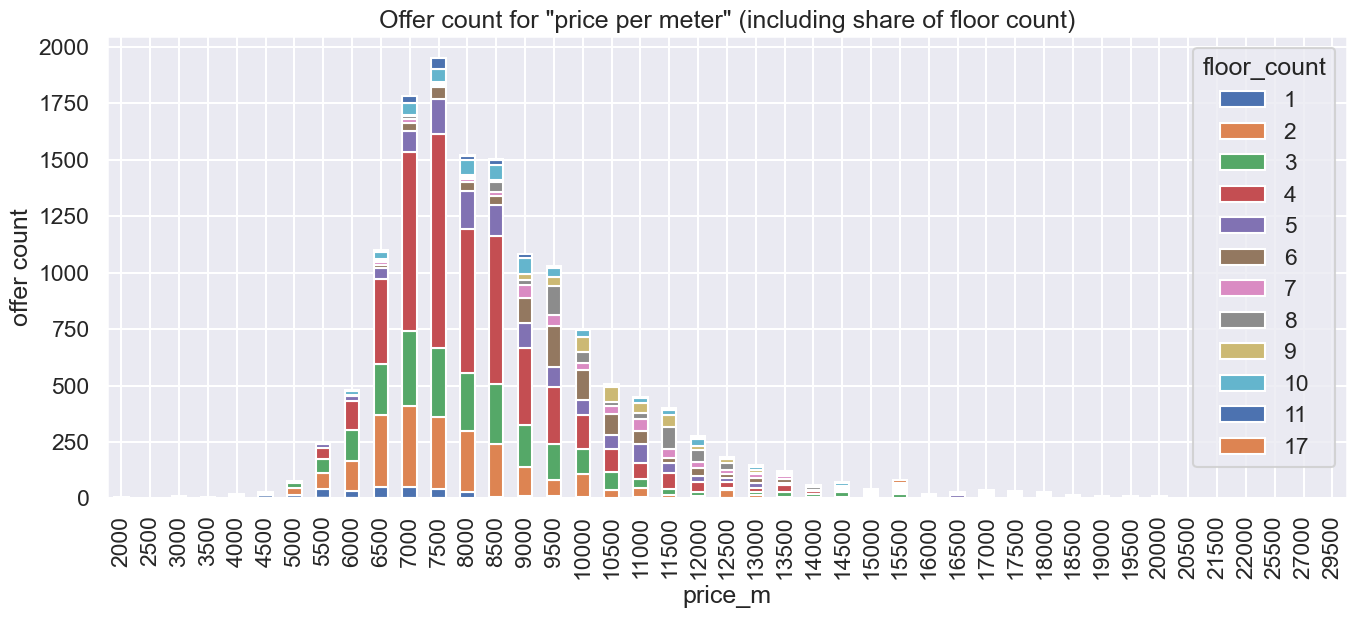

In [24]:
index = df[df['floor_count'] != 0]['floor_count'].value_counts()[0:12].index
dfs = df[['price_m', 'floor_count']][df['floor_count'].isin(index)]
dfs = dfs.pivot_table(index='price_m', columns='floor_count', aggfunc=len)
ax = dfs.plot(kind='bar', stacked=True, figsize=[16,6], xlim=(4000,15000))
ax.set(xlabel='price_m', ylabel='offer count', title='Offer count for "price per meter" (including share of floor count)')
plt.show()

### Relationship between Price per Meter and Offer Count by Apartment's Floor in Offer

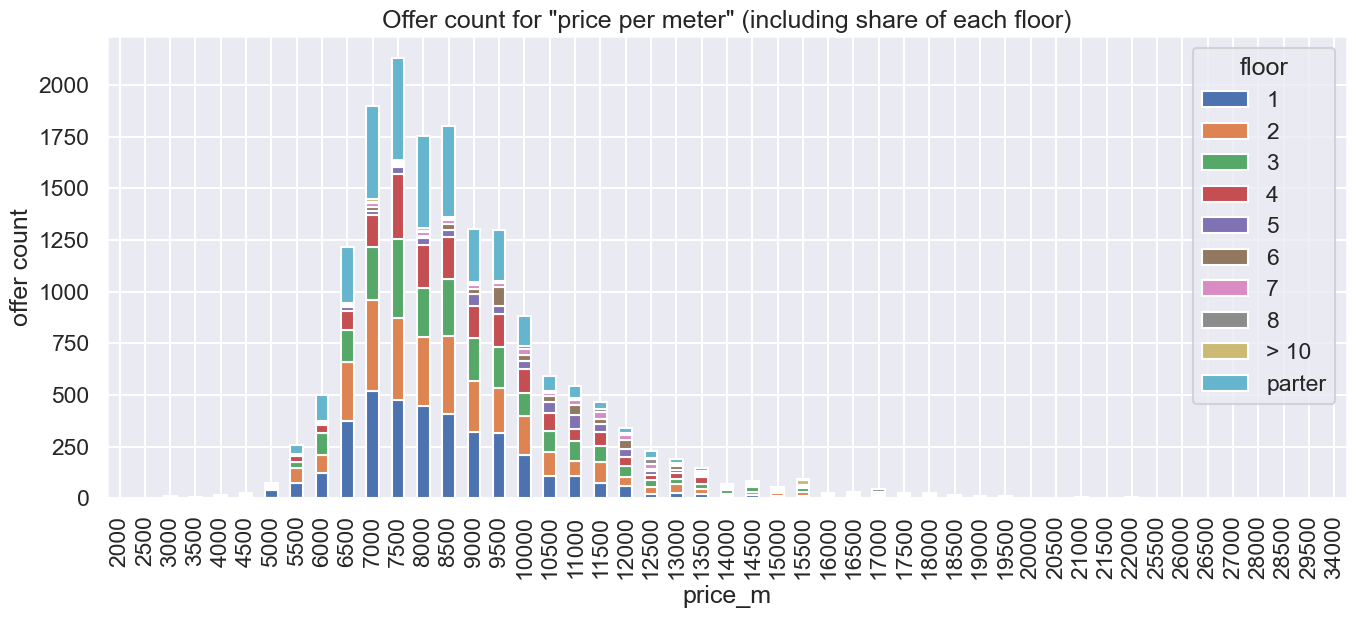

In [25]:
index = df[df['floor'] != '0']['floor'].value_counts()[0:10].index
dfs = df[['price_m', 'floor']][df['floor'].isin(index)]
dfs = dfs.pivot_table(index='price_m', columns='floor', aggfunc=len)
ax = dfs.plot(kind='bar', stacked=True, figsize=[16,6], xlim=(4000,15000))
ax.set(xlabel='price_m', ylabel='offer count', title='Offer count for "price per meter" (including share of each floor)')
plt.show()

## Interesting searches and example queries

Search for skyscapers. These offers are all located in the same building: Sky Tower

In [26]:
view = ['id','price','price_m','area','room','year','loc','url','winda', 'floor', 'floor_count']
df.query('floor_count>20')[view].head(10)

,id,price,price_m,area,room,year,loc,url,winda,floor,floor_count
267,ID49RPU,2037420,18500,106,3,2010,"Wrocław, Krzyki, Gwiaździsta",https://www.otodom.pl/pl/oferta/ID49RPU,1.0,> 10,51
1584,ID4aCY7,899000,16000,56,2,2000,"Wrocław, Krzyki",https://www.otodom.pl/pl/oferta/ID4aCY7,1.0,> 10,51
1814,ID4aLPn,1350000,26000,50,2,2010,"Wrocław, Krzyki, Gwiaździsta",https://www.otodom.pl/pl/oferta/ID4aLPn,1.0,> 10,31
3294,ID490v9,1800000,18500,96,3,2010,"Wrocław, Krzyki, Gwiaździsta",https://www.otodom.pl/pl/oferta/ID490v9,1.0,> 10,51
3454,ID3C6qv,6000000,27000,220,4,2010,"Wrocław, Krzyki, ul. Powstańców Śląskich",https://www.otodom.pl/pl/oferta/ID3C6qv,1.0,> 10,51
3508,ID4a4Xz,2150000,19500,108,3,2010,"Wrocław, Krzyki, ul. Gwiaździsta",https://www.otodom.pl/pl/oferta/ID4a4Xz,1.0,> 10,49
3846,ID49M1f,1350000,26000,50,2,2010,"Wrocław, Krzyki",https://www.otodom.pl/pl/oferta/ID49M1f,1.0,> 10,51
3951,ID49FL2,1199999,21000,56,2,2010,"Wrocław, dolnośląskie",https://www.otodom.pl/pl/oferta/ID49FL2,1.0,> 10,49
4321,ID49bnY,1200000,21000,56,1,2010,"Wrocław, Krzyki",https://www.otodom.pl/pl/oferta/ID49bnY,0.0,> 10,49
4502,ID48RXh,1200000,21000,56,1,2010,"Wrocław, Krzyki, Gwiaździsta",https://www.otodom.pl/pl/oferta/ID48RXh,0.0,> 10,49


Search for offers with apartment on 5th, without elevator. Locations are known for their old "kamienice", multi-story tenement houses that typically do not have elevators. 

In [27]:
df.query('floor_count==5 & floor=="5" & winda==0')[view]

,id,price,price_m,area,room,year,loc,url,winda,floor,floor_count
139,ID4aIaD,560000,7500,72,2,0,"Wrocław, Śródmieście, Plac Grunwaldzki, Szczyt...",https://www.otodom.pl/pl/oferta/ID4aIaD,0.0,5,5
159,ID46e5I,369000,7000,50,2,1990,"Wrocław, Fabryczna, Kuźniki, Dźwirzyńska",https://www.otodom.pl/pl/oferta/ID46e5I,0.0,5,5
160,ID492BE,658000,8000,80,4,1990,"Wrocław, Nadodrze, ul. Kręta",https://www.otodom.pl/pl/oferta/ID492BE,0.0,5,5
274,ID48HXF,640000,6500,90,5 and more,2000,"Wrocław, Śródmieście, Stanisława Dubois",https://www.otodom.pl/pl/oferta/ID48HXF,0.0,5,5
504,ID4aBO6,299000,13000,22,1,0,"Wrocław, Śródmieście, ul. kard. Stefana Wyszyń...",https://www.otodom.pl/pl/oferta/ID4aBO6,0.0,5,5
...,...,...,...,...,...,...,...,...,...,...,...
17087,ID46GC5,1575900,11000,140,4,2020,"Wrocław, Śródmieście",https://www.otodom.pl/pl/oferta/ID46GC5,0.0,5,5
17233,ID468Jk,1199400,11500,100,3,2020,"Wrocław, Stare Miasto, ok. Rynku",https://www.otodom.pl/pl/oferta/ID468Jk,0.0,5,5
17255,ID462TB,1321500,11500,110,4,2020,"Wrocław, Nadodrze, ok. Pl. Bema",https://www.otodom.pl/pl/oferta/ID462TB,0.0,5,5
17278,ID45h1a,292320,9500,30,2,2020,"Wrocław, Krzyki, Jagodno, Buforowa",https://www.otodom.pl/pl/oferta/ID45h1a,0.0,5,5


Search for private offers with a construction year before 1939 with balcon.

In [28]:
df.query('year<1939 & year>0 & seller=="Oferta prywatna" & balkon==1')[view].sort_values(by='price', ascending=False)

,id,price,price_m,area,room,year,loc,url,winda,floor,floor_count
2049,ID4aIN5,830000,8500,92,4,1930,"Wrocław, Krzyki, Borek, ul. Racławicka",https://www.otodom.pl/pl/oferta/ID4aIN5,0.0,1,2
869,ID4aQ53,660000,6500,98,5 and more,1930,"Wrocław, Śródmieście, Centrum, ul. Karola Marc...",https://www.otodom.pl/pl/oferta/ID4aQ53,0.0,2,3
1874,ID4awz6,585000,6500,84,3,1920,"Wrocław, Śródmieście, ul. Stefana Żeromskiego 29",https://www.otodom.pl/pl/oferta/ID4awz6,0.0,3,4
822,ID4aqxH,579000,7000,80,3,1930,"Karłowice, Wrocław, dolnośląskie",https://www.otodom.pl/pl/oferta/ID4aqxH,0.0,parter,2
487,ID48ybB,570000,8000,68,3,1930,"Wrocław, Fabryczna, Grabiszyn",https://www.otodom.pl/pl/oferta/ID48ybB,0.0,2,5
536,ID4aIYG,415000,16500,24,1,1850,"Wrocław, Stare Miasto, ul. Staromłyńska",https://www.otodom.pl/pl/oferta/ID4aIYG,1.0,1,5




##### Some revisions were made with the assistance of ChatGPT https://chat.openai.com/chat
Thank you for your attention!